# Import required modules

In [ ]:
%%time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


!python3.9 -m pip install -qU --upgrade pip
!python3.9 -m pip install -qU requests opencv-python numpy pandas scikit-learn tensorflow==2.5.0

import os
import shutil
import cv2
import glob
import gzip
import random
import pickle
import pandas
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.python.layers.layers import flatten
from sklearn.utils import shuffle

tf.disable_v2_behavior()

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://githu

# Download dataset

In [ ]:
%%time

FILES = ['test.p', 'train.p', 'valid.p']
SOURCE = "https://rawgit.com/thevickypedia/open-source/main/traffic-signs-data/"


def download_file(filename):
    filename += '.gz'
    if os.path.exists(os.path.join(os.path.realpath('traffic-signs-data'), filename)):
        return
    url = SOURCE + filename
    with requests.get(url, stream=True) as r:
        print(f'Downloading gzipped file: {filename}')
        with open(os.path.join(os.path.realpath('traffic-signs-data'), filename), 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f'Unzipping file: {filename}')
        with gzip.open(os.path.join(os.path.realpath('traffic-signs-data'), filename), 'rb') as f_in:
            with open(os.path.join(os.path.realpath('traffic-signs-data'), filename.rstrip('.gz')), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(os.path.join(os.path.realpath('traffic-signs-data'), filename))


futures = {}
executor = ThreadPoolExecutor(max_workers=len(FILES))
with executor:
    for file in FILES:
        future = executor.submit(download_file, file)
        futures[future] = file

for future in as_completed(futures):
    if future.exception():
        exit(f'Thread processing for `{file}` received an exception: {future.exception()}')


Unzipping file: test.p.gz
Unzipping file: train.p.gz
Unzipping file: valid.p.gz
CPU times: user 1.32 s, sys: 515 ms, total: 1.84 s
Wall time: 9.16 s


# Step1: Load The Data

In [ ]:
%%time

# Load pickled data
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

label2Name = {}
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#Load sign names file
signs_names = []
df = pandas.read_csv('./traffic-signs-data/signnames.csv')
for name in df['SignName']:
    signs_names.append(name)

CPU times: user 6.62 ms, sys: 85.5 ms, total: 92.1 ms
Wall time: 98.3 ms


# Summary of Dataset

In [ ]:
n_train = X_train.shape[0] 
n_validation = X_valid.shape[0] 
n_test = X_test.shape[0]
image_shape = X_train.shape[1:] 
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization of Dataset

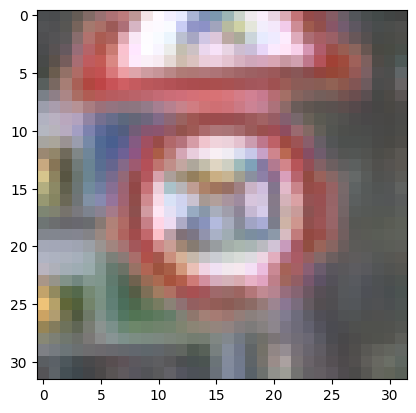

In [ ]:
plt.imshow(X_train[0])

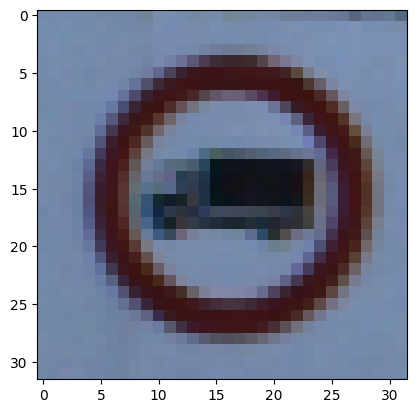

In [ ]:
plt.imshow(X_test[0])

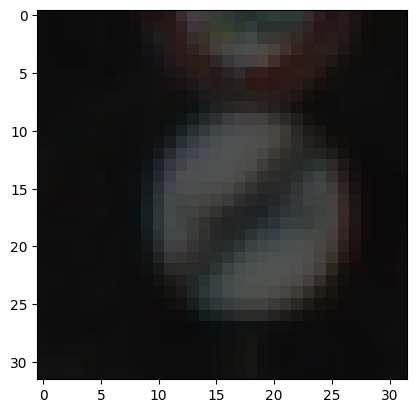

In [ ]:
plt.imshow(X_valid[0])

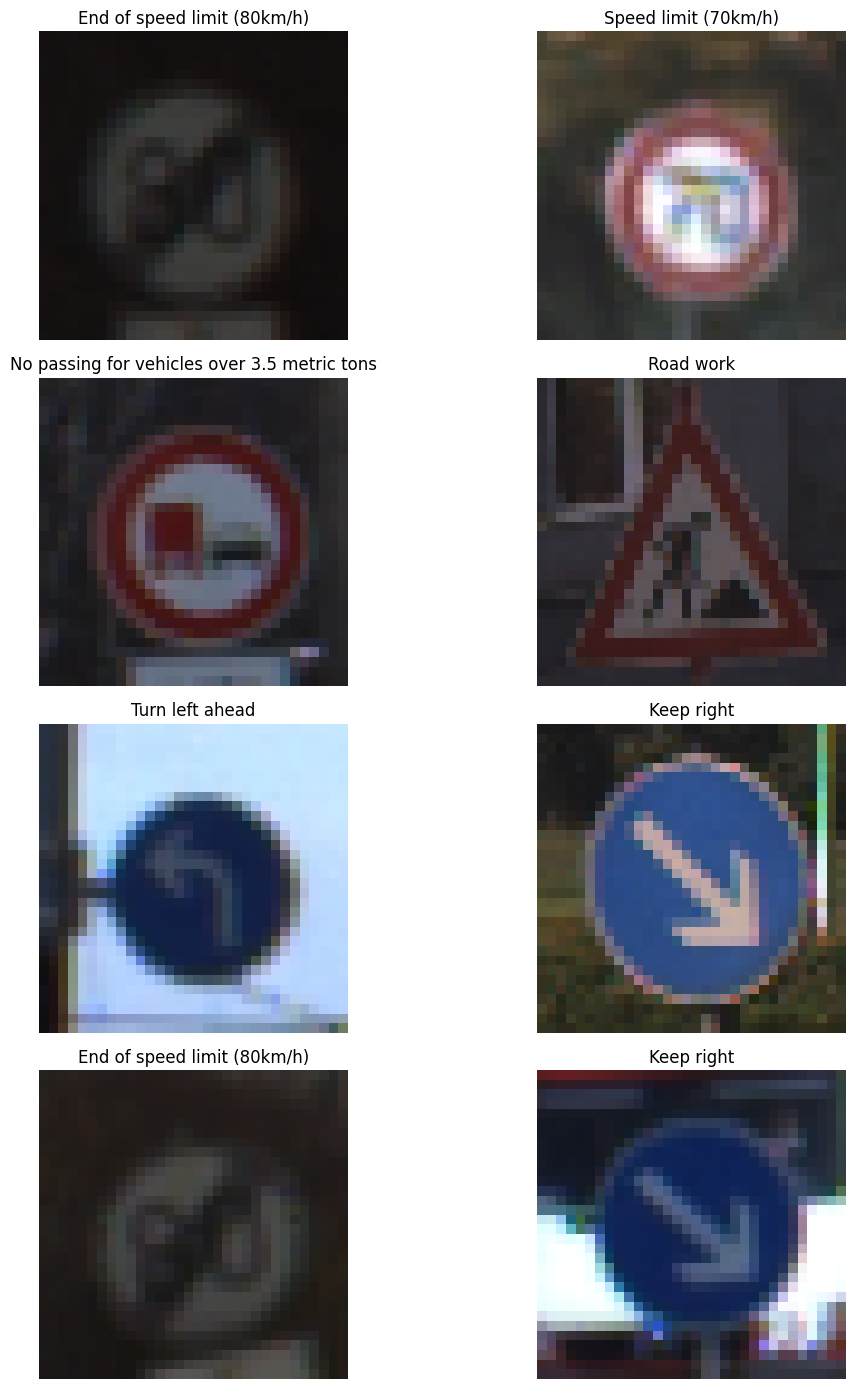

In [ ]:
%matplotlib inline

def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()
    
name_values = np.genfromtxt('./traffic-signs-data/signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')
    
number_to_stop = 8
figures = {}
labels = {}
for i in range(number_to_stop):
    index = random.randint(0, n_train-1)
    labels[i] = name_values[y_train[index]][1].decode('ascii')
#     print(name_values[y_train[index]][1].decode('ascii'))
    figures[i] = X_train[index]

plot_figures(figures, 4, 2, labels)

## Label distribution

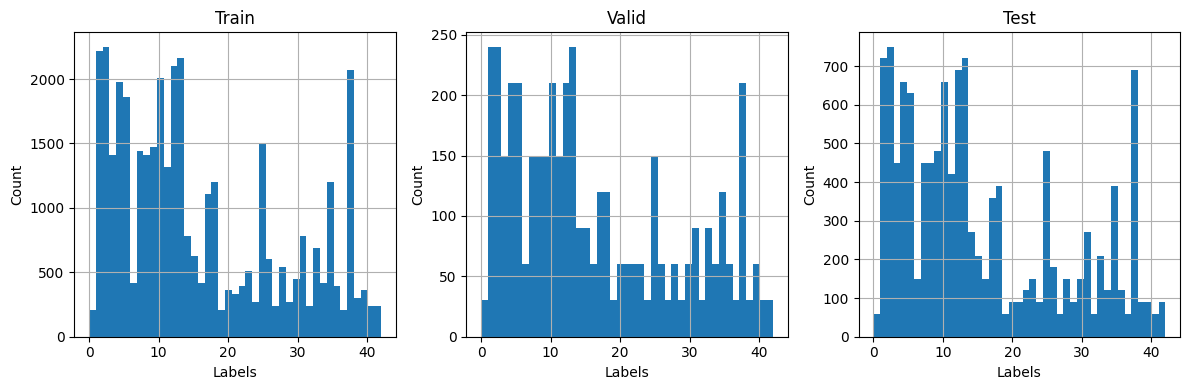

In [ ]:
def plotLabelHistogram(labels, titles, number_of_labels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `number_of_labels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))

    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes, labels, titles):
#         n, bins, patches = ax.hist(label, number_of_labels, normed=1)
        n, bins, patches = ax.hist(label, number_of_labels)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Rotation')

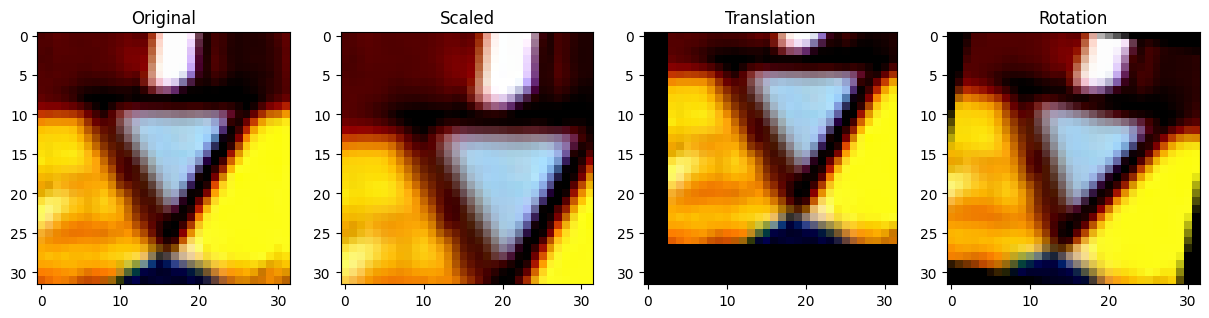

In [ ]:
def transform(img, type = 0):
    if type == 0:
        fx = random.uniform(1.0, 1.3)
        fy = random.uniform(1.0, 1.3)
        return cv2.resize(img,None,fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)[0:32, 0:32,:]

    if type == 1: # Translation
        rY = random.randint(-5, 5)
        rX = random.randint(-5, 5)
        M = np.float32([[1,0,rY],[0,1,rX]])
    else:
        angle = random.randint(-90, 90)
        M = cv2.getRotationMatrix2D((16,16),angle,1)

    return cv2.warpAffine(img,M,(32,32))

fig, axes = plt.subplots(ncols=4, figsize=(15,10))
randomIndex = random.randint(0, len(X_train))
axes[0].imshow(X_train[randomIndex])
axes[0].set_title('Original')
axes[1].imshow(transform(X_train[randomIndex], 0))
axes[1].set_title('Scaled')
axes[2].imshow(transform(X_train[randomIndex], 1))
axes[2].set_title('Translation')
axes[3].imshow(transform(X_train[randomIndex], 2))
axes[3].set_title('Rotation')

/var/folders/9m/l33vjgts7lg4tlfgfs4zmxd40000gn/T/ipykernel_19229/241330783.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, _ = np.histogram(input_labels, 43, normed=True)


New images count 80451


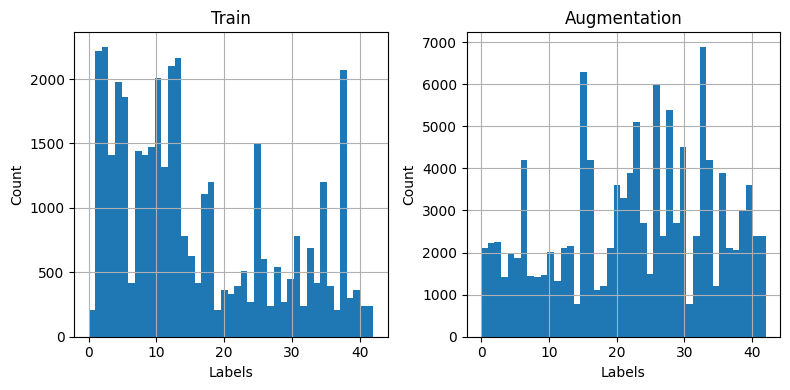

In [ ]:
def generateImages(input, input_labels):
    hist, _ = np.histogram(input_labels, 43, normed=True)
    selectedLabel = []
    for index, v in enumerate(hist):
        if v < 0.02:
            selectedLabel.append(index)
    newInput = []
    newLabels = []
    for index, label in enumerate(input_labels):
        if label in selectedLabel:
            for i in range(0,9):
                type = random.randint(0, 3)
                newLabels.append(label)
                newInput.append(transform(input[index], type))
    
    return (np.array(newInput), np.array(newLabels))

X_train_new, y_train_new = generateImages(X_train, y_train)
print('New images count {}'.format(len(X_train_new)))
added = np.concatenate((y_train, y_train_new), axis=0)
plotLabelHistogram([y_train, added], ['Train', 'Augmentation'], n_classes)
X_train = np.concatenate((X_train, X_train_new), axis=0)
y_train = np.concatenate((y_train, y_train_new), axis=0)

# Train, Validate and Test the Model

In [ ]:
EPOCHS = 25
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,  n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.00070

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
%%time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...\n")
    validation_accuracy_figure = []
    train_accuracy_figure = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)

        train_accuracy = evaluate(X_train, y_train)
        train_accuracy_figure.append(train_accuracy)
        print("EPOCH {}".format(i+1))
        print("Train Accuracy = {:.2f} %".format(train_accuracy * 100))
        print("Validation Accuracy = {:.2f} %".format(validation_accuracy * 100) + "\n")

    saver.save(sess, './lenet')
    print("Model saved")

2025-01-01 12:35:14.067934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training...

EPOCH 1
Train Accuracy = 63.13 %
Validation Accuracy = 49.71 %

EPOCH 2
Train Accuracy = 80.30 %
Validation Accuracy = 62.15 %

EPOCH 3
Train Accuracy = 87.68 %
Validation Accuracy = 73.02 %

EPOCH 4
Train Accuracy = 92.39 %
Validation Accuracy = 78.73 %

EPOCH 5
Train Accuracy = 93.90 %
Validation Accuracy = 83.47 %

EPOCH 6
Train Accuracy = 95.61 %
Validation Accuracy = 84.20 %

EPOCH 7
Train Accuracy = 97.17 %
Validation Accuracy = 85.90 %

EPOCH 8
Train Accuracy = 98.01 %
Validation Accuracy = 82.56 %

EPOCH 9
Train Accuracy = 98.12 %
Validation Accuracy = 85.96 %

EPOCH 10
Train Accuracy = 98.70 %
Validation Accuracy = 87.53 %

EPOCH 11
Train Accuracy = 98.55 %
Validation Accuracy = 82.27 %

EPOCH 12
Train Accuracy = 99.16 %
Validation Accuracy = 88.16 %

EPOCH 13
Train Accuracy = 98.98 %
Validation Accuracy = 90.09 %

EPOCH 14
Train Accuracy = 99.18 %
Validation Accuracy = 90.02 %

EPOCH 15
Train Accuracy = 99.44 %
Validation Accuracy = 90.57 %

EPOCH 16
Train Accura

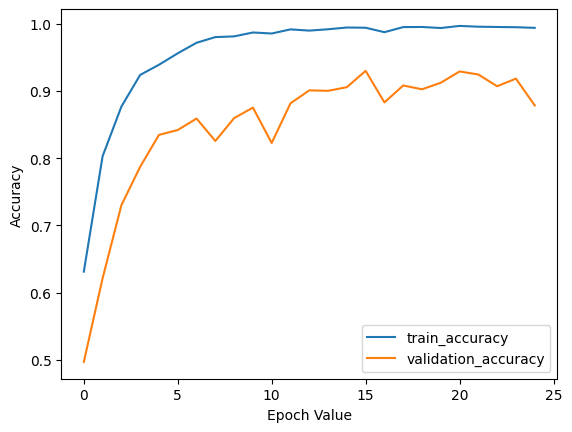

In [ ]:
plt.plot(train_accuracy_figure, label='train_accuracy')
plt.plot(validation_accuracy_figure, label='validation_accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.legend(frameon=True)
plt.show()

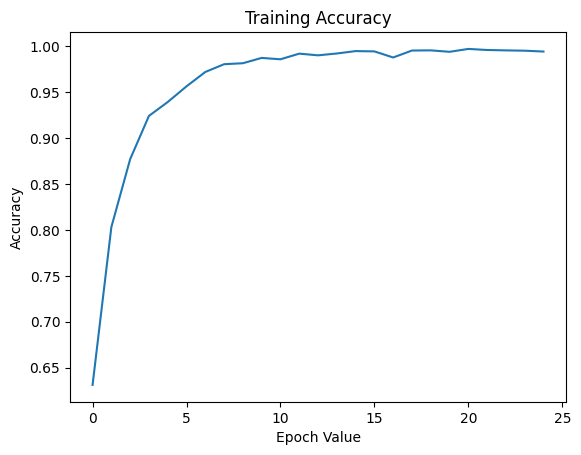

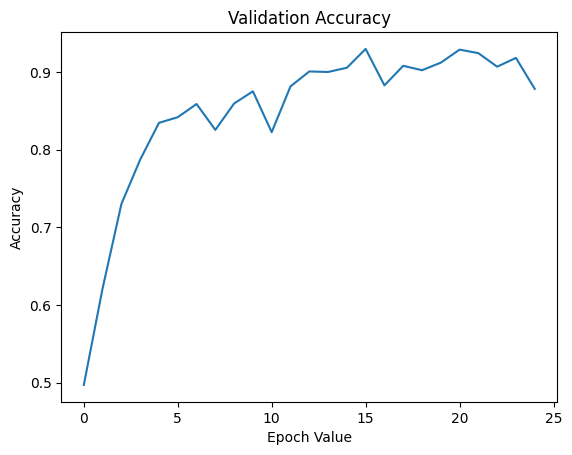

In [ ]:
plt.plot(train_accuracy_figure)
plt.title("Training Accuracy")
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.show()

plt.plot(validation_accuracy_figure)
plt.title("Validation Accuracy")
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.2f}".format(train_accuracy * 100))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.3f}".format(valid_accuracy * 100))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy * 100))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 99.39
Valid Accuracy = 87.846
Test Accuracy = 77.704


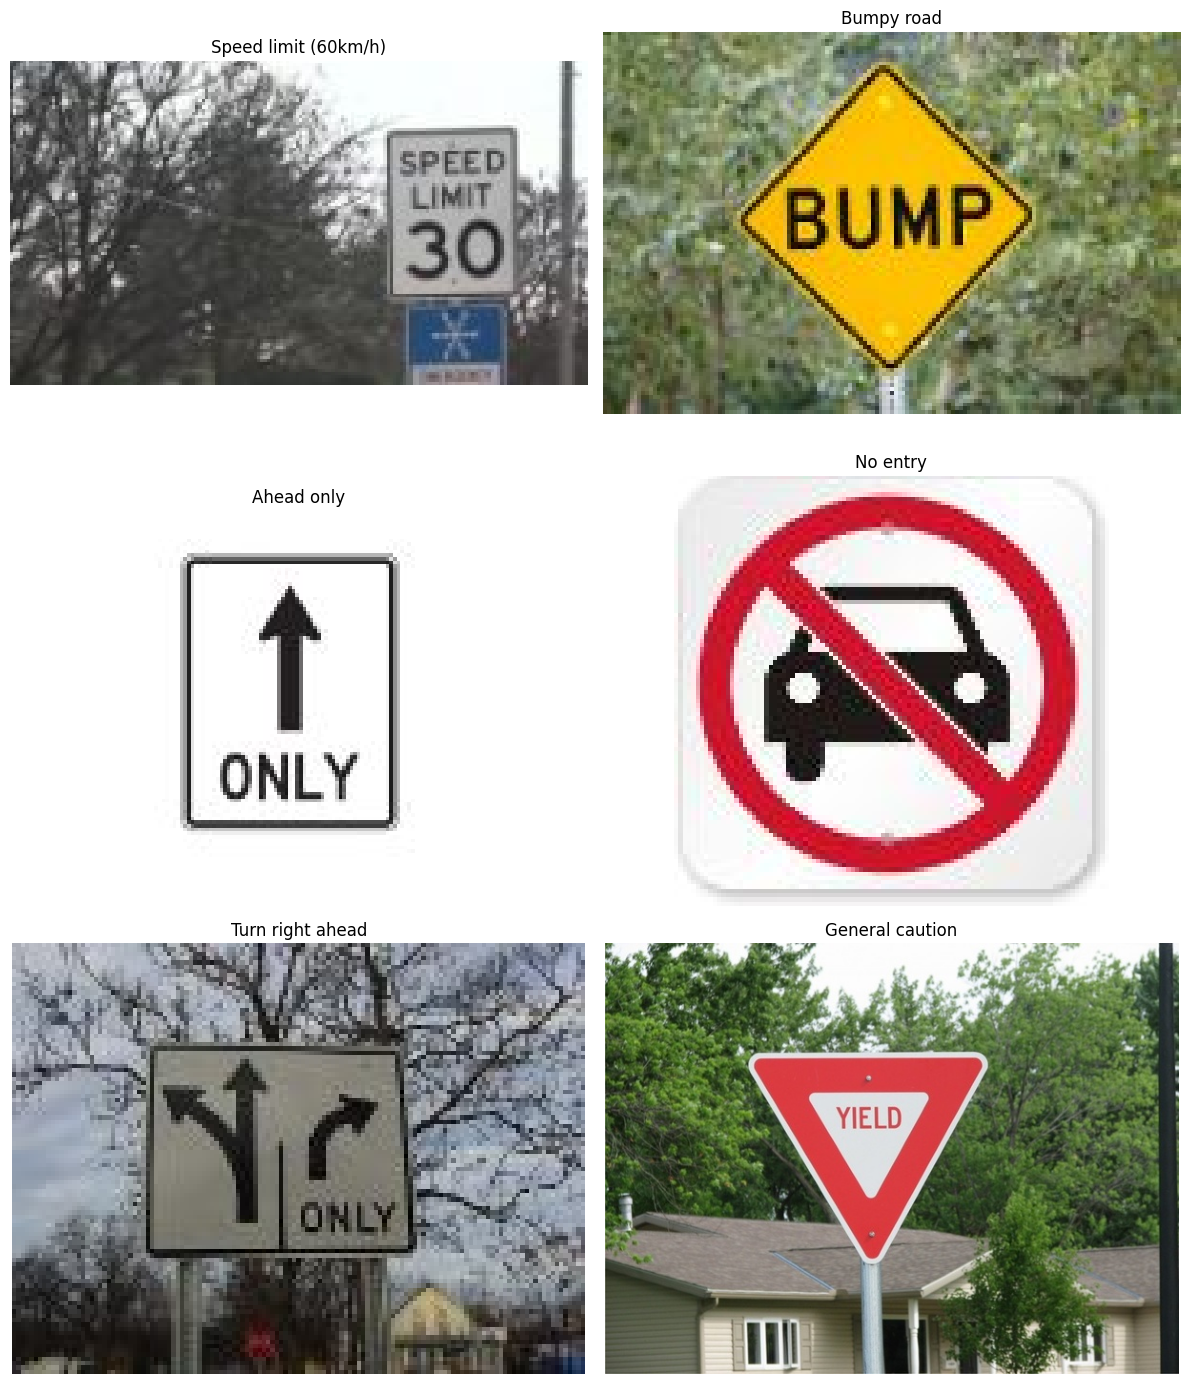

In [ ]:
my_images = sorted(glob.glob('./test-images/*.jpg'))
my_labels = np.array([3, 22, 35, 17, 33, 18])

figures = {}
labels = {}
my_signs = []
for index, my_image in enumerate(my_images):
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')

plot_figures(figures, 3, 2, labels)

In [ ]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'DATA/train.p'
validation_file= 'DATA/valid.p'
testing_file = 'DATA/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_rgb, y_train = train['features'], train['labels']
X_valid_rgb, y_valid = valid['features'], valid['labels']
X_test_rgb, y_test = test['features'], test['labels']

print()
print("Image Shape: {}".format(X_train_rgb[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_rgb)))
print("Validation Set: {} samples".format(len(X_valid_rgb)))
print("Test Set:       {} samples".format(len(X_test_rgb)))



Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [ ]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train_rgb)

# TODO: Number of validation examples
n_validation = len(X_valid_rgb)

# TODO: Number of testing examples.
n_test = len(X_test_rgb)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_rgb[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


34


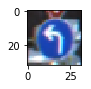

In [ ]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train_rgb))
image = X_train_rgb[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

### Train, Validate and Test the Model

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.002

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    validation_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(validation_accuracy))
    
    training_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(training_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.825

EPOCH 2 ...
Validation Accuracy = 0.888

EPOCH 3 ...
Validation Accuracy = 0.893

EPOCH 4 ...
Validation Accuracy = 0.908

EPOCH 5 ...
Validation Accuracy = 0.909

EPOCH 6 ...
Validation Accuracy = 0.900

EPOCH 7 ...
Validation Accuracy = 0.911

EPOCH 8 ...
Validation Accuracy = 0.924

EPOCH 9 ...
Validation Accuracy = 0.920

EPOCH 10 ...
Validation Accuracy = 0.925

EPOCH 11 ...
Validation Accuracy = 0.918

EPOCH 12 ...
Validation Accuracy = 0.932

EPOCH 13 ...
Validation Accuracy = 0.923

EPOCH 14 ...
Validation Accuracy = 0.919

EPOCH 15 ...
Validation Accuracy = 0.923

EPOCH 16 ...
Validation Accuracy = 0.933

EPOCH 17 ...
Validation Accuracy = 0.929

EPOCH 18 ...
Validation Accuracy = 0.929

EPOCH 19 ...
Validation Accuracy = 0.936

EPOCH 20 ...
Validation Accuracy = 0.939

EPOCH 21 ...
Validation Accuracy = 0.928

EPOCH 22 ...
Validation Accuracy = 0.935

EPOCH 23 ...
Validation Accuracy = 0.949

EPOCH 24 ...
Validation Accura

Unedited German Traffic light Images from the internets


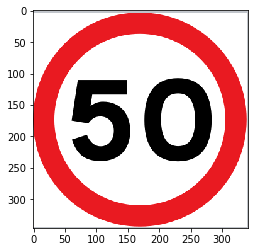

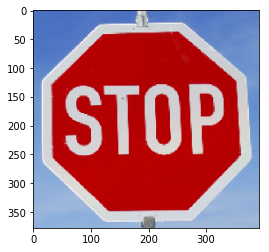

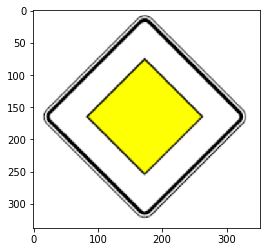

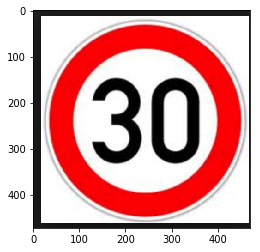

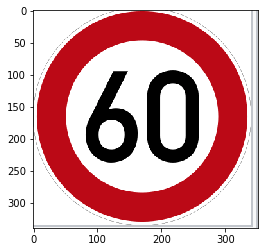

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Unedited German Traffic light Images from the internets")

def process(filename):
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)

process('DATA/pic1.png')
process('DATA/pic2.png')
process('DATA/pic3.png')
process('DATA/pic4.png')
process('DATA/pic5.png')


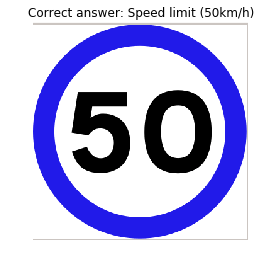

[ 66.00414276  26.74353027  -8.63586903 -16.94047165 -28.67375755]
['Roundabout mandatory', 'Speed limit (80km/h)', 'General caution', 'Speed limit (50km/h)', 'Right-of-way at the next intersection']
['Roundabout mandatory(66.0)', 'Speed limit (80km/h)(27.0)', 'General caution(-9.0)', 'Speed limit (50km/h)(-17.0)', 'Right-of-way at the next intersection(-29.0)']


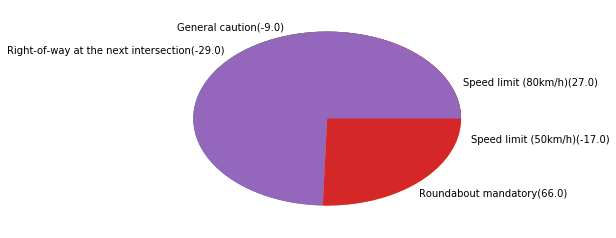

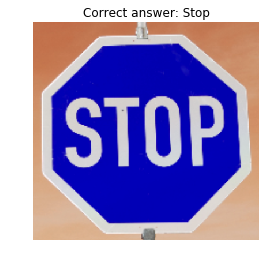

[ 66.623909    18.14672852  17.70209503   5.68860149   1.33462238]
['Stop', 'Speed limit (120km/h)', 'Speed limit (70km/h)', 'Double curve', 'Priority road']
['Stop(67.0)', 'Speed limit (120km/h)(18.0)', 'Speed limit (70km/h)(18.0)', 'Double curve(6.0)', 'Priority road(1.0)']


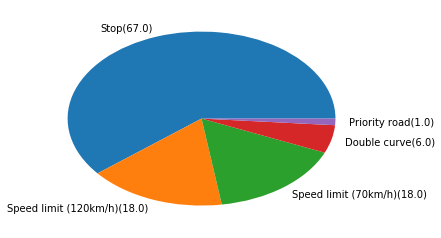

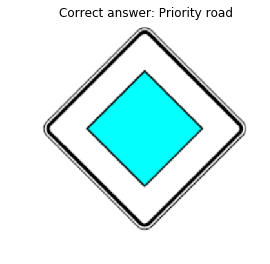

[ 88.73298645  26.95794296  12.45810127   7.46036959  -7.10931921]
['Priority road', 'Children crossing', 'No vehicles', 'Keep right', 'Roundabout mandatory']
['Priority road(89.0)', 'Children crossing(27.0)', 'No vehicles(12.0)', 'Keep right(7.0)', 'Roundabout mandatory(-7.0)']


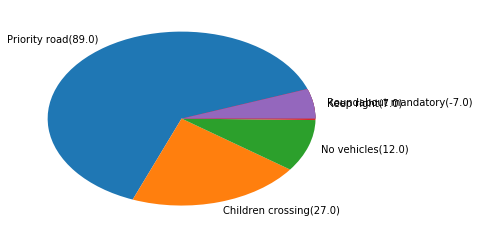

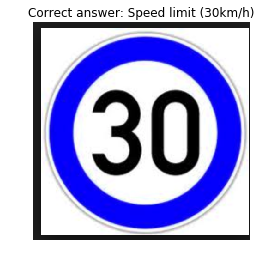

[ 171.30393982   63.27350616   62.20495224   57.21661377   27.28001595]
['Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (100km/h)', 'Keep right', 'Speed limit (80km/h)']
['Speed limit (30km/h)(171.0)', 'Speed limit (50km/h)(63.0)', 'Speed limit (100km/h)(62.0)', 'Keep right(57.0)', 'Speed limit (80km/h)(27.0)']


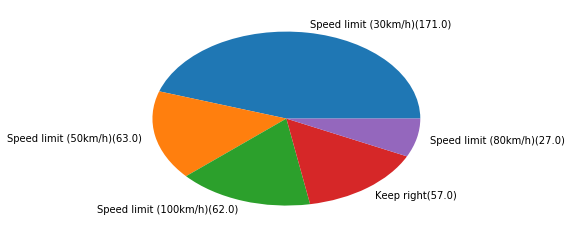

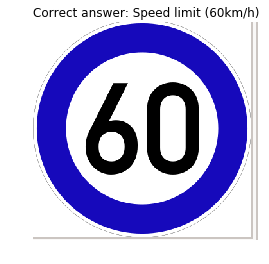

[ 147.01431274   81.48052979   56.02854538   18.50650406   15.6884346 ]
['Speed limit (30km/h)', 'Speed limit (50km/h)', 'Keep right', 'Keep left', 'Speed limit (100km/h)']
['Speed limit (30km/h)(147.0)', 'Speed limit (50km/h)(81.0)', 'Keep right(56.0)', 'Keep left(19.0)', 'Speed limit (100km/h)(16.0)']


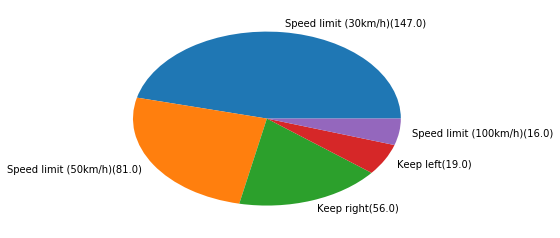

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

import pandas as pd

signs_names = []
df = pd.read_csv('./signnames.csv')
for name in df['SignName']:
    signs_names.append(name)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    soft_max_probs = sess.run(tf.nn.top_k(logits, k = 5) , feed_dict={x: my_images_normalized, y: my_labels})
    
prob_names = []
for prob in soft_max_probs[1]:
    names = []
    for id in prob:
        names.append(signs_names[id])
    prob_names.append(names)
    
for i in range(len(my_test_images)):
    plt.imshow(my_test_images[i]) 
    plt.title("Correct answer: " + signs_names[my_labels[i]])
    plt.axis('off')
    plt.show()
    c = soft_max_probs[0][i]
    print(c)
    print(prob_names[i])
    
    concatinated = [str(n)+"("+str(round(m))+")" for m,n in zip(c,prob_names[i])]
    print(str(concatinated))
    
    plt.pie(soft_max_probs[0][i], labels=concatinated)
    plt.show()